# Clasificación multiclase

En este modelo se implementa el one vs all para el dataset que contiene grafos de enlaces a paginas de facebook el cual se divide en 4 clases de páginas (tvshow, goverment, company y politician) y se usan las siguientes librerias para lograr trabajar con One vs All en este modelo.

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Preprocesamiento

Preparamos los datos para ser leidos a traves de pandas para luego crear una matriz de adyacencia que nos dara los valores de los nodos e identificadores para crear listas, mapear las páginas y asignar las etiquetas . 

In [28]:
# Cargar datos
edges = pd.read_csv('musae_facebook_edges.csv')
target = pd.read_csv('musae_facebook_target.csv')

# Preparación de datos para One-vs-All
def prepare_data(edges, target):
    # Crear matriz de adyacencia dispersa
    nodes = sorted(set(edges['id_1'].unique()) | set(edges['id_2'].unique()))
    node_to_index = {node: idx for idx, node in enumerate(nodes)}
    
    # Crear listas para la matriz dispersa
    row_indices = []
    col_indices = []
    
    for _, row in edges.iterrows():
        i, j = node_to_index[row['id_1']], node_to_index[row['id_2']]
        row_indices.extend([i, j])
        col_indices.extend([j, i])
    
    # Crear matriz dispersa
    X = csr_matrix(([1]*len(row_indices), (row_indices, col_indices)), 
                   shape=(len(nodes), len(nodes)))
    
    # Mapear tipos de páginas
    page_types = target.set_index('id')['page_type']
    type_mapping = {
        'tvshow': 0, 
        'government': 1, 
        'company': 2, 
        'politician': 3
    }
    
    # Asignar etiquetas
    y = np.zeros(len(nodes), dtype=int)
    for node in nodes:
        idx = node_to_index[node]
        if node in page_types.index:
            y[idx] = type_mapping[page_types.loc[node]]
    
    return X, y, type_mapping

# Modificar la preparación de datos
X, y, type_mapping = prepare_data(edges, target)

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (22470, 22470)
Dimensiones de y: (22470,)


# División

Dividi el modelo en datos de prueba y entrenamiento 

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Obtener X e y originalmente
X, y, type_mapping = prepare_data(edges, target)

# Filtrar nodos etiquetados
valid_mask = y != 0
X_filtered = X[valid_mask].toarray()  # Convertir a array denso solo para este paso
y_filtered = y[valid_mask]

# Normalizar características
X_normalized = StandardScaler().fit_transform(X_filtered)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, 
    y_filtered, 
    test_size=0.2,  
    random_state=42,  
    stratify=y_filtered
)

print("Información de la división de datos:")
print(f"Número de nodos de entrenamiento: {len(X_train)}")
print(f"Número de nodos de prueba: {len(X_test)}")

Información de la división de datos:
Número de nodos de entrenamiento: 15314
Número de nodos de prueba: 3829


# Implementación y Entrenamiento

Empezamos a usar el One Vs All para entrenar el modelo utilizando el descenso por el gradiente y regularización, al igual que rastreamos las metricas como la perdida y precisión tanto para los datos de entrenamiento como para los de prueba y finalmente usando sigmoid para la obtencion de probabilidades, lrCostFunction para el costo y predictOneVsAll para las precisiones.

In [56]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def lrCostFunction(theta, X, y, lambda_):
    m = len(y)
    theta = theta.reshape(-1, 1)  # Aseguramos que theta es un vector columna
    y = y.reshape(-1, 1)  # Aseguramos que y es un vector columna
    
    # Calcular hipótesis
    h = sigmoid(X.dot(theta))
    
    # Evitar errores numéricos
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1-epsilon)
    
    # Término de regularización
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
    
    # Función de costo
    J = (-1/m) * (y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h))) + reg_term
    
    # Gradiente
    grad = (1/m) * X.T.dot(h - y)
    grad[1:] += (lambda_/m) * theta[1:]
    
    # Convertir el costo a escalar
    return float(J[0, 0]), grad.flatten()

def oneVsAll(X, y, X_test, y_test, num_labels, lambda_, max_epochs=60):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n+1))
    
    # Añadir columna de unos
    X_augmented = np.column_stack([np.ones(m), X])
    X_test_augmented = np.column_stack([np.ones(X_test.shape[0]), X_test])
    
    # Listas para almacenar métricas
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []
    
    # Para cada época
    for epoch in range(max_epochs):
        # Actualizar todos los clasificadores
        for c in range(num_labels):
            # Si es la primera época, inicializar los pesos
            if epoch == 0:
                all_theta[c] = np.zeros(n+1)
            
            # Preparar etiquetas binarias para esta clase
            binary_y_train = (y == c).astype(int)
            
            # Calcular gradiente para esta clase
            _, grad = lrCostFunction(all_theta[c], X_augmented, binary_y_train, lambda_)
            
            # Actualizar pesos con descenso de gradiente (learning rate = 0.1)
            all_theta[c] = all_theta[c] - 0.1 * grad
        
        # Calcular costo total de entrenamiento
        train_cost = 0
        for c in range(num_labels):
            binary_y_train = (y == c).astype(int)
            cost, _ = lrCostFunction(all_theta[c], X_augmented, binary_y_train, lambda_)
            train_cost += float(cost)
        
        # Calcular costo total de prueba
        test_cost = 0
        for c in range(num_labels):
            binary_y_test = (y_test == c).astype(int)
            cost, _ = lrCostFunction(all_theta[c], X_test_augmented, binary_y_test, lambda_)
            # Asegurarnos de que cost es un escalar
            test_cost += float(cost)
        
        # Calcular precisión de entrenamiento
        train_pred = predictOneVsAll(all_theta, X)
        train_accuracy = float(np.mean(train_pred == y))
        
        # Calcular precisión de prueba
        test_pred = predictOneVsAll(all_theta, X_test)
        test_accuracy = float(np.mean(test_pred == y_test))
        
        # Guardar métricas
        train_costs.append(train_cost)
        test_costs.append(test_cost)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Mostrar progreso
        if epoch % 1 == 0 or epoch == max_epochs - 1:
            print(f"Época {epoch}: "
                  f"Train Loss = {float(train_cost):.4f}, "
                  f"Test Loss = {float(test_cost):.4f}, "
                  f"Train Acc = {float(train_accuracy):.4f}, "
                  f"Test Acc = {float(test_accuracy):.4f}")
    
    return all_theta, train_costs, test_costs, train_accuracies, test_accuracies

def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X_augmented = np.column_stack([np.ones(m), X])
    
    # Calcular probabilidades para cada clase
    predictions = sigmoid(X_augmented.dot(all_theta.T))
    
    # Seleccionar la clase con mayor probabilidad
    return np.argmax(predictions, axis=1)

lambda_ = 0.1
num_labels = 4

# Entrenar modelo solo con datos de entrenamiento
all_theta, train_costs, test_costs, train_accuracies, test_accuracies = oneVsAll(X_train, y_train, X_test, y_test, num_labels, lambda_)

# Predecir en datos de prueba
predictions = predictOneVsAll(all_theta, X_test)

# Calcular precisión
accuracy = np.mean(predictions == y_test) * 100
print(f"Precisión del modelo en datos de prueba: {accuracy:.2f}%")


Época 0: Train Loss = 2.7350, Test Loss = 2.7348, Train Acc = 0.4139, Test Acc = 0.4095
Época 1: Train Loss = 2.6992, Test Loss = 2.6989, Train Acc = 0.4158, Test Acc = 0.4113
Época 2: Train Loss = 2.6652, Test Loss = 2.6648, Train Acc = 0.4173, Test Acc = 0.4124
Época 3: Train Loss = 2.6329, Test Loss = 2.6324, Train Acc = 0.4210, Test Acc = 0.4145
Época 4: Train Loss = 2.6022, Test Loss = 2.6016, Train Acc = 0.4224, Test Acc = 0.4168
Época 5: Train Loss = 2.5731, Test Loss = 2.5723, Train Acc = 0.4246, Test Acc = 0.4192
Época 6: Train Loss = 2.5453, Test Loss = 2.5444, Train Acc = 0.4270, Test Acc = 0.4205
Época 7: Train Loss = 2.5188, Test Loss = 2.5178, Train Acc = 0.4289, Test Acc = 0.4218
Época 8: Train Loss = 2.4937, Test Loss = 2.4926, Train Acc = 0.4308, Test Acc = 0.4231
Época 9: Train Loss = 2.4697, Test Loss = 2.4685, Train Acc = 0.4338, Test Acc = 0.4247
Época 10: Train Loss = 2.4468, Test Loss = 2.4456, Train Acc = 0.4359, Test Acc = 0.4270
Época 11: Train Loss = 2.4250, 

# Gráficas

Creamos las graficas del costo y la precision para ambos conjuntos de prueba y entrenamiento para ver la mejora de la precision del modelo.

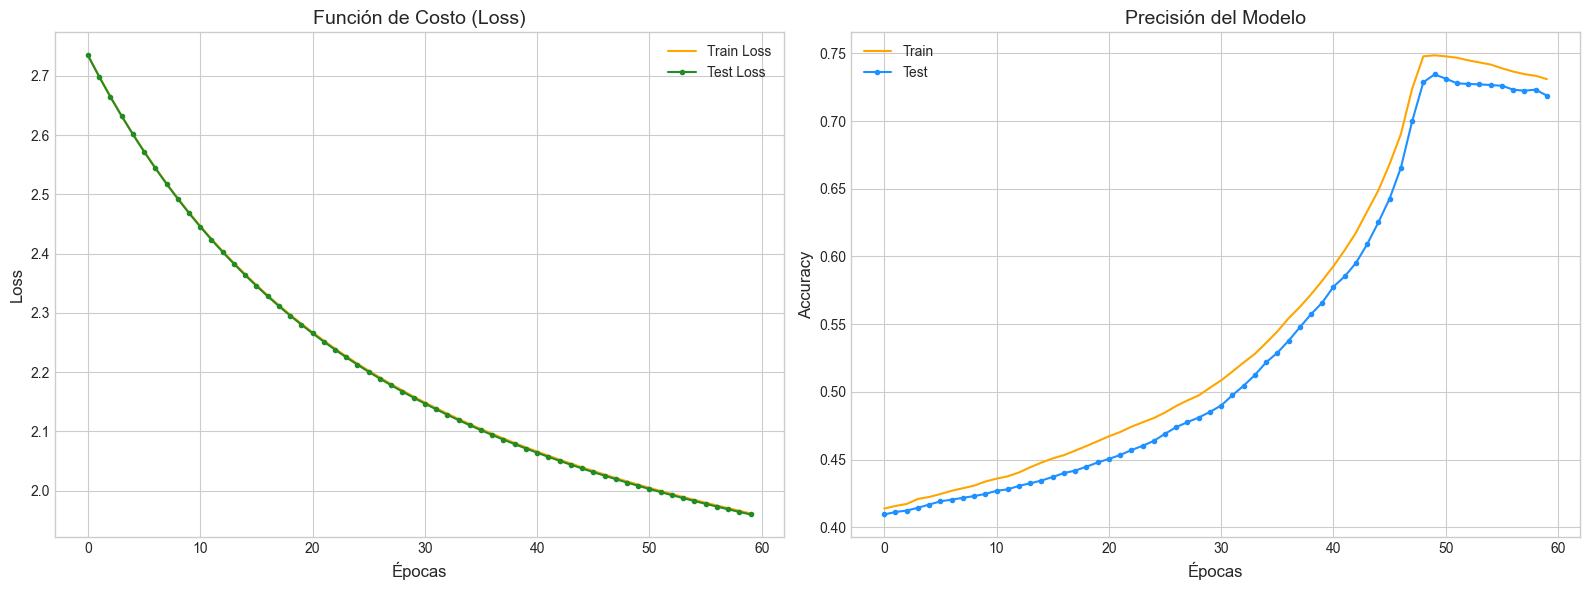

In [65]:
def plot_metrics(train_costs, test_costs, train_accuracies, test_accuracies):
    """
    Genera gráficas similares a las proporcionadas, mostrando la evolución
    del costo y la precisión a lo largo de las épocas
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Obtener las épocas (índices)
    epochs = np.arange(len(train_costs))
    
    # Configurar estilo de matplotlib similar al mostrado
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfica de función de costo (Loss)
    ax1.plot(epochs, train_costs, color='#FFA500', label='Train Loss')
    ax1.plot(epochs, test_costs, color='#228B22', marker='o', markersize=3, label='Test Loss')
    ax1.set_title('Función de Costo (Loss)', fontsize=14)
    ax1.set_xlabel('Épocas', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    
    # Gráfica de precisión del modelo
    ax2.plot(epochs, train_accuracies, color='#FFA500', label='Train')
    ax2.plot(epochs, test_accuracies, color='#1E90FF', marker='o', markersize=3, label='Test')
    ax2.set_title('Precisión del Modelo', fontsize=14)
    ax2.set_xlabel('Épocas', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()

plot_metrics(train_costs, test_costs, train_accuracies, test_accuracies)

# Interpretación

Clasificamos 4 páginas de Facebook usando One Vs All con una precision final de 71.87% usando grafos para poder trabajar con este dataset y entrenarlo usando el descenso del gradiente para optimizar los parámetros, sigmoid para tener las probabilidades y graficas que nos demuestran el costo y la precision en los datos de entrenamiento y prueba